### Background
E-commerce companies like Amazon , Flipkart etc. use different recommendation systems to provide suggestions to the customers. Amazon uses currently item-item collaberrative filtering, which scales to massive datasets and produces high quality recommendation system in the real time. This system is a kind of an information filtering system which seeks to predict the "rating" or preferences which user is interested in.

### Data Description:
Amazon Reviews data (data source) The repository has several datasets. For this case study, we are using the Electronics dataset.

### Attribute Information:
● userId : Every user identified with a unique id

● productId : Every product identified with a unique id

● Rating : Rating of the corresponding product by the corresponding user

● timestamp : Time of the rating ( ignore this column for this exercise)

### Domain:
E-commerce

### Objective:
Build a recommendation system to recommend products to customers based on the their previous ratings for other products.

In [1]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

### Loading and Checking the Dataset

In [2]:
Electronics_df = pd.read_csv('ratings_Electronics.csv')

In [3]:
Electronics_df.shape

(7824481, 4)

#### Assigning Columns

In [4]:
Electronics_df.columns = ['UserId','ProductId','Rating','Timestamp']

#### Checking for Missing values

In [5]:
print('Number of missing values across columns: \n',Electronics_df.isnull().sum())

Number of missing values across columns: 
 UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64


#### Dropping Null Values

In [6]:
Electronics_df = Electronics_df.dropna()

#### Data Exploration

In [7]:
Electronics_df.head()

,UserId,ProductId,Rating,Timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [8]:
Electronics_df.dtypes

UserId        object
ProductId     object
Rating       float64
Timestamp      int64
dtype: object

In [9]:
Electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
UserId       object
ProductId    object
Rating       float64
Timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 298.5+ MB


In [10]:
Electronics_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,7824481.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
Timestamp,7824481.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


In [11]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(Electronics_df.Rating.min()))
print('Maximum rating is: %d' %(Electronics_df.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [12]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",Electronics_df.shape[0])
print("Total No of Users   :", len(np.unique(Electronics_df.UserId)))
print("Total No of products  :", len(np.unique(Electronics_df.ProductId)))

Total data 
--------------------------------------------------

Total no of ratings : 7824481
Total No of Users   : 4201696
Total No of products  : 476001


#### Observation :

There are two independent variables ( Rating and Timestamp).

There are 7824481 rows and 4 columns.

All the records are numeric.

Time Stamp is integer and the rating column is float type.

Memory usage is 299 MB.

There are no null values in the data.

The total number of ratings in the datset are 7824481, the number of users are 4201696 and the total number of products are 476001

#### Dropping the TimeStamp Column

The time stamp column is being dropped as it is of no significant use in our analysis and model building

In [13]:
Electronics_df.drop(['Timestamp'], axis=1,inplace=True)

### Taking the subset of dataset to make it less sparse/ denser.

In [14]:
#Taking subset of the dataset
New_df=Electronics_df.iloc[:1048576,0:]

The dataset is locked at 1048576 cells as these are the maximum num ber of visible cells in an excel sheet

In [15]:
#Check the top 10 users based on ratings
most_rated=New_df.groupby('UserId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 UserId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
AKT8TGIT6VVZ5     122
A11D1KHM7DVOQK    112
A2B7BUH8834Y6M    103
A3OXHLG6DIBRW8     95
A203OCQQ12MAVT     90
dtype: int64


#### Unique Users and products in the subset of the dataset

In [16]:
# Number of unique user id  in the data
print('Number of unique users in Subset = ', New_df['UserId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Subset = ', New_df['ProductId'].nunique())

Number of unique users in Subset =  786330
Number of unique product in Subset =  61893


#### Checking the distribution of ratings


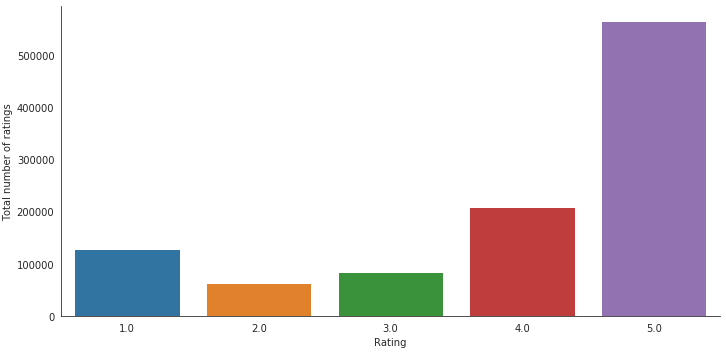

In [17]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=New_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

Most of the people have given a rating of 5

In [18]:
counts=New_df.UserId.value_counts()
New_df=New_df[New_df.UserId.isin(counts[counts>=50].index)]
print('Number of users who have rated 50 or more items =', len(New_df))
print('Number of unique users in the final data = ', New_df['UserId'].nunique())
print('Number of unique products in the final data = ', New_df['UserId'].nunique())

Number of users who have rated 50 or more items = 3456
Number of unique users in the final data =  38
Number of unique products in the final data =  38


#### Analyzing the rating

In [19]:
no_of_rated_products_per_user = New_df.groupby(by='UserId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

UserId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [20]:
no_of_rated_products_per_user.describe()

count     38.000000
mean      90.947368
std       65.757518
min       50.000000
25%       61.500000
50%       69.500000
75%       89.500000
max      412.000000
Name: Rating, dtype: float64

In [21]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

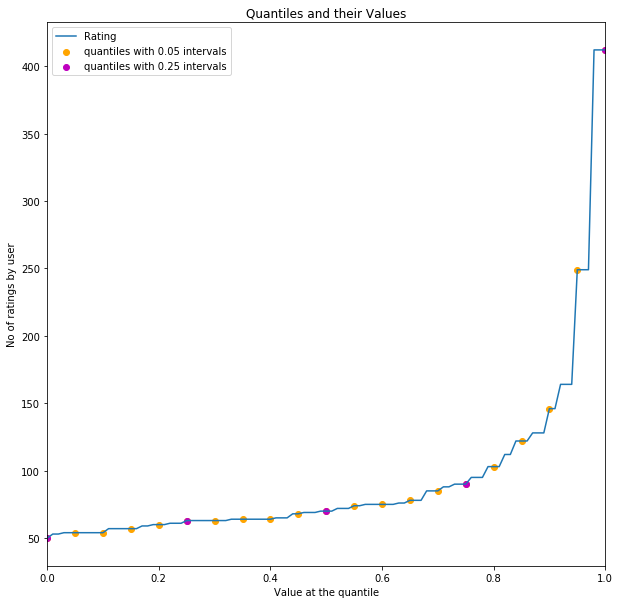

In [22]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [23]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 38



In [24]:
#constructing the pivot table
final_ratings_matrix = New_df.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
final_ratings_matrix.head()

ProductId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
UserId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1435P5AMCPB3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A15QYHQH80W30L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It shows that it is a sparse matrix. So, many cells are filled with 0 values.

In [25]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (38, 2943)


We can see that there are 38 products and 2943 users.

In [26]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  3456
possible_num_of_ratings =  111834
density: 3.09%


The density value of the matrix also shows that it is a sparse matrix.

### Splitting the data into trainset and testset

In [27]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(New_df, test_size = 0.3, random_state=0)
train_data.head()

,UserId,ProductId,Rating
480024,A1JWSDDIH5Z7DV,B0002KQR1Y,5.0
971309,A1FR68QH6Z4YZM,B000GHTGES,5.0
107108,A6FIAB28IS79,B00005N6KF,4.0
605401,AKT8TGIT6VVZ5,B0007OV45O,5.0
240458,A2R6RA8FRBS608,B000087NBU,4.0


In [28]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (2419, 3)
Shape of testing data:  (1037, 3)


### Popularity Based Recommendation
Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that personalization is not available with this method i.e. even though the behaviour of the user is known, items cannot be recommended accordingly.

In [29]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'Score'},inplace=True)
train_data_grouped.head(50)

,ProductId,Score
0,1400532655,1
1,998376234X,1
2,B000001OL6,1
3,B000001OMI,1
4,B000001OMN,1
5,B00000DM9W,1
6,B00000J061,1
7,B00000J0A2,1
8,B00000J0E8,1
9,B00000J1G6,1


In [30]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['Score', 'ProductId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['Score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,ProductId,Score,Rank
110,B00004SB92,5,1.0
235,B00004ZCJE,5,2.0
1775,B0009RKL5S,5,3.0
478,B0000645C9,4,4.0
860,B00008OE46,4,5.0


In [31]:
# Use popularity based recommender model to make predictions
def recommend(User_id):     
    user_recommendations = popularity_recommendations 
          
    #Add User_id column for which the recommendations are being generated 
    user_recommendations['UserId'] = User_id 
      
    #Bring User_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [32]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the UserId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the UserId: 10

      UserId   ProductId  Score  Rank
110       10  B00004SB92      5   1.0
235       10  B00004ZCJE      5   2.0
1775      10  B0009RKL5S      5   3.0
478       10  B0000645C9      4   4.0
860       10  B00008OE46      4   5.0


The list of recommendations for the UserId: 100

      UserId   ProductId  Score  Rank
110      100  B00004SB92      5   1.0
235      100  B00004ZCJE      5   2.0
1775     100  B0009RKL5S      5   3.0
478      100  B0000645C9      4   4.0
860      100  B00008OE46      4   5.0


The list of recommendations for the UserId: 150

      UserId   ProductId  Score  Rank
110      150  B00004SB92      5   1.0
235      150  B00004ZCJE      5   2.0
1775     150  B0009RKL5S      5   3.0
478      150  B0000645C9      4   4.0
860      150  B00008OE46      4   5.0




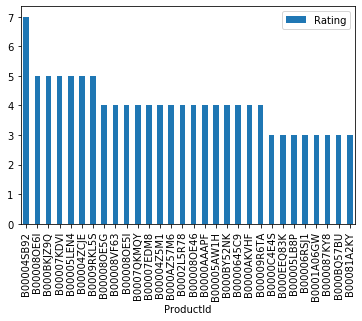

In [33]:
popular_products = pd.DataFrame(New_df.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

Since this is a popularity-based recommender model, recommendations remain the same for all users

We predict the products based on the popularity. It is not personalized to particular user

### Model-based collaborative filtering system
These methods are based on machine learning and data mining techniques. These algorithms provide item recommendation by first developing a model of user ratings. Algorithms in this category take a probabilistic approach and envision the collaborative filtering process as computing the expected value of a user prediction, given his/her ratings on other items.. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [34]:
New_df=New_df.head(10000)
ratings_matrix = New_df.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_matrix.head()

ProductId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
UserId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
A12DLJESJKM1OQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1435P5AMCPB3X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A149RNR5RH19YY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A15QYHQH80W30L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
ratings_matrix.shape

(38, 2943)

In [36]:
# Transposing the matrix
X = ratings_matrix.T
X.head()

UserId,A11D1KHM7DVOQK,A12DLJESJKM1OQ,A1435P5AMCPB3X,A149RNR5RH19YY,A15QYHQH80W30L,A1F9Z42CFF9IAY,A1FR68QH6Z4YZM,A1JWSDDIH5Z7DV,A1MJMYLRTZ76ZX,A1ODOGXEYECQQ8,...,A6FIAB28IS79,A7Y6AVS576M03,ABH9D1TEOJ56E,AGHZXQL9F94T9,AGXV8E7XK9J6H,AKT8TGIT6VVZ5,ALUNVOQRXOZIA,AT2J7H5TRZM8Z,AT6CZDCP4TRGA,AWPODHOB4GFWL
ProductId,,,,,,,,,,,,,,,,,,,,,
1400532655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400599997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9043413585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998376234X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B000000O48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
X.shape

(2943, 38)

In [38]:
# Unique products in subset of data
X1 = X

In [39]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(2943, 10)

In [40]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(2943, 2943)

In [41]:
X.index[75]

'B00001WRSJ'

In [42]:
# Index # of product ID purchased by customer
i = "B00001WRSJ"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [43]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(2943,)

In [44]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:25]

['B00000J1UU',
 'B00000J3II',
 'B00000JDGO',
 'B00000JFOF',
 'B00000K0KJ',
 'B00000K1SF',
 'B00000K4KU',
 'B00001ZWPF',
 'B0000296HA',
 'B00004R8V6',
 'B00004S9WR',
 'B00004SYVL',
 'B00004TDN2',
 'B00004TL5Q',
 'B00004TX7E',
 'B00004WGTA',
 'B00004Y284',
 'B00004ZD36',
 'B0000507JI',
 'B000051JUL',
 'B000052WM4',
 'B000053HC5',
 'B000055YX6',
 'B000059YXK',
 'B00005A9AV']

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

Recommending top 25 highly correlated products in sequence

### User based Collaberative filtering
The method identifies users that are similar to the queried user and estimate the desired rating to be the weighted average of the ratings of these similar users

In [45]:
New_df1 = pd.concat([train_data, test_data]).reset_index()
New_df1.head()

,index,UserId,ProductId,Rating
0,480024,A1JWSDDIH5Z7DV,B0002KQR1Y,5.0
1,971309,A1FR68QH6Z4YZM,B000GHTGES,5.0
2,107108,A6FIAB28IS79,B00005N6KF,4.0
3,605401,AKT8TGIT6VVZ5,B0007OV45O,5.0
4,240458,A2R6RA8FRBS608,B000087NBU,4.0


In [46]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = New_df1.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
pivot_df.head()

ProductId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
UserId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1435P5AMCPB3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A15QYHQH80W30L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (38, 2943)


In [48]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ProductId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788,user_index
UserId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1435P5AMCPB3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A15QYHQH80W30L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [49]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

ProductId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As this is a sparse matrix we will use SVD.

### Singular Value Decomposition

In [50]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

In [51]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-6.64161696e-02  4.31528153e-04  3.37786414e-03  4.12558392e-02
  -2.89722101e-02  1.79284225e-02  3.02342026e-03 -3.52112579e-04
   2.45397452e-03  1.04887971e-02]
 [-1.80197050e-02  7.68657333e-04  7.20544067e-03  2.62748695e-02
  -1.97320291e-02  1.92531155e-02  1.69864914e-03  5.95174021e-03
  -1.93268622e-02  2.72017747e-02]
 [-6.86727933e-02 -1.49434527e-02  8.11418685e-02  1.90458879e-02
  -8.60896456e-03  2.13284435e-03  3.43354825e-04 -2.10703364e-04
   3.18370938e-03  1.15138368e-02]
 [ 1.53478750e-02  4.83314743e-03 -1.30024203e-02  3.99558068e-02
  -3.46573069e-03  3.87274114e-02  1.88223811e-03 -4.41856025e-07
  -1.09124307e-02  6.90452643e-03]
 [-7.19210074e-03  1.99921755e-03  3.61877490e-02  1.28627831e-02
  -7.04467382e-03 -1.12413800e-03  5.42691695e-02 -1.27481833e-03
   3.13621954e-03  1.13870943e-02]
 [-2.96100557e-02 -7.69782564e-02  4.25563509e-02  2.03047194e-02
  -7.02441403e-02  4.29041203e-02  3.21266108e-02 -3.38399429e-03
  -2.2940

In [52]:
print('Sigma: \n',sigma)

Sigma: 
 [41.89390301 42.28479703 43.75491809 44.00142731 45.99811068 51.84242495
 53.59174684 63.49228847 69.36014162 84.88630491]


As sigma is not a diagonal matrix we will have to convert it into diagonal matrix.

In [53]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[41.89390301  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         42.28479703  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         43.75491809  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         44.00142731  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         45.99811068  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         51.84242495
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  53.59174684  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         63.49228847  0.          0.        ]
 [ 0.          0.          0.        

In [54]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 3.00429861e-04 -2.16836488e-04 -1.06233760e-03 ... -4.89206972e-03
  -9.75210221e-03 -3.04423019e-03]
 [ 5.38321607e-05 -1.70440674e-04  5.66590559e-04 ... -1.62514374e-04
  -7.42849482e-03  1.75242360e-03]
 [-1.74432819e-04  2.35572803e-05  2.30102014e-04 ... -2.53627309e-03
  -1.56138806e-04  1.39847434e-03]
 ...
 [-1.42106588e-04  5.60662786e-05 -3.67721847e-05 ...  8.97313402e-05
  -1.74896872e-05 -1.50392450e-03]
 [ 2.85425835e-03 -2.18521938e-04 -6.66857252e-05 ... -2.98607167e-04
  -6.73184268e-05 -1.06387085e-03]
 [ 1.15174070e-02  3.20653634e-05  1.04420164e-04 ...  5.50434939e-04
   5.04878181e-05  1.45121449e-03]]


In [55]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ProductId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
0,0.008496,0.000975,0.017130,0.009489,0.002576,0.273672,0.006995,0.014822,-0.001294,0.008682,...,0.007360,0.006995,0.042479,0.025488,-0.001294,0.004197,0.060605,0.047444,0.035227,0.026392
1,0.021403,0.000907,0.011784,0.005400,0.006628,0.098021,0.007664,0.006926,0.001527,0.038343,...,0.048133,0.007664,0.107014,0.064208,0.001527,0.004598,0.024748,0.027002,0.013018,0.019467
2,0.009910,0.000870,0.008238,0.004004,0.001872,0.262368,0.034362,0.012063,-0.000689,-0.031076,...,0.353545,0.034362,0.049551,0.029731,-0.000689,0.020617,0.058273,0.020021,0.035347,0.018342
3,0.003421,0.000552,0.013528,0.006192,0.001947,-0.000054,0.000268,0.002867,0.005244,0.102796,...,-0.010295,0.000268,0.017107,0.010264,0.005244,0.000161,0.004767,0.030960,-0.000254,0.010970
4,0.009934,0.000145,0.005831,0.002463,-0.000078,0.046547,0.016904,0.003214,-0.000880,-0.005246,...,0.188454,0.016904,0.049672,0.029803,-0.000880,0.010142,0.011490,0.012314,0.004482,0.022131


In [56]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [57]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B000FQ2JLW                  0.0          0.409358
B000EOPQ7E                  0.0          0.375093
B0002L5R78                  0.0          0.345041
B00009RUCH                  0.0          0.336283
B00004Z5M1                  0.0          0.286030


In [58]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B00004ZCJE                  0.0          0.579875
B0000UA3MA                  0.0          0.541374
B000GHDPHC                  0.0          0.541374
B0001U6RNI                  0.0          0.528805
B00008GT9Y                  0.0          0.515756


In [59]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B00022TN9A                  0.0          0.827527
B000E6G9RI                  0.0          0.821428
B0007XOHTU                  0.0          0.813451
B0002INUIY                  0.0          0.813451
B000AEFVVE                  0.0          0.813451


Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

### Evaluation of Collabrative recommendation model

In [60]:
# Actual ratings given by the users
final_ratings_matrix.head()

ProductId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
UserId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1435P5AMCPB3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A15QYHQH80W30L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

ProductId
1400532655    0.026316
1400599997    0.026316
9043413585    0.078947
998376234X    0.026316
B000000O48    0.131579
dtype: float64

In [62]:
# Predicted ratings 
preds_df.head()

ProductId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
0,0.008496,0.000975,0.017130,0.009489,0.002576,0.273672,0.006995,0.014822,-0.001294,0.008682,...,0.007360,0.006995,0.042479,0.025488,-0.001294,0.004197,0.060605,0.047444,0.035227,0.026392
1,0.021403,0.000907,0.011784,0.005400,0.006628,0.098021,0.007664,0.006926,0.001527,0.038343,...,0.048133,0.007664,0.107014,0.064208,0.001527,0.004598,0.024748,0.027002,0.013018,0.019467
2,0.009910,0.000870,0.008238,0.004004,0.001872,0.262368,0.034362,0.012063,-0.000689,-0.031076,...,0.353545,0.034362,0.049551,0.029731,-0.000689,0.020617,0.058273,0.020021,0.035347,0.018342
3,0.003421,0.000552,0.013528,0.006192,0.001947,-0.000054,0.000268,0.002867,0.005244,0.102796,...,-0.010295,0.000268,0.017107,0.010264,0.005244,0.000161,0.004767,0.030960,-0.000254,0.010970
4,0.009934,0.000145,0.005831,0.002463,-0.000078,0.046547,0.016904,0.003214,-0.000880,-0.005246,...,0.188454,0.016904,0.049672,0.029803,-0.000880,0.010142,0.011490,0.012314,0.004482,0.022131


In [63]:
# Average PREDICTED rating for each item
preds_df.mean().head()

ProductId
1400532655    0.030646
1400599997    0.002071
9043413585    0.025324
998376234X    0.009998
B000000O48    0.008305
dtype: float64

In [64]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(2943, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
ProductId,,,
1400532655,0.026316,0.030646,0
1400599997,0.026316,0.002071,1
9043413585,0.078947,0.025324,2
998376234X,0.026316,0.009998,3
B000000O48,0.131579,0.008305,4


In [65]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.07375 



### Getting top - K ( K = 5) recommendations

In [66]:
# Enter 'UserID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B000050AQ7                  0.0          1.521771
B0002Z240M                  0.0          1.433002
B00004Z5M1                  0.0          1.428022
B0009RKL6M                  0.0          1.412477
B000067VBL                  0.0          1.392806


### Closing Comments:
Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history